# ARTstract Model Training
### Delfina Sol Martinez Pandiani (delfinasol.martinez2@studio.unibo.it)
#### February 2023

In this notebook, I attempt to develop a multi-label image classifier for abstract concepts. Specifically, I attempt to classify images into twelve target classes. I have used the ARTstract dataset, which I created by mining and collecting images and annotations from art and cultural image datasets, as specified in [1].

[1] https://github.com/delfimpandiani/ARTstract_Seeing_abstract_concepts

In [ ]:
#========================================================================================================================
#========================================================================================================================
#==================================================MY MODEL=============================================================
#========================================================================================================================
#========================================================================================================================

# PERFORMANCE OF MY MODEL JUST ON TRAINING AND VAL DATA WITHOUT AUGMENTED TRAINING DATA
# 465/824 [===============>..............] - ETA: 51s - loss: 1.0595 - accuracy: 0.6488 val_loss: 2.1318 - val_accuracy: 0.4123


# PERFORMANCE OF MY MODEL IN !TEST! DATA WITHOUT AUGMENTED TRAINING DATA
# 103/103 [==============================] - 5s 48ms/step - loss: 2.6025 - accuracy: 0.3996

#========================================================================================================================
# PERFORMANCE OF MY MODEL JUST ON TRAINING AND VAL DATA !WITH! AUGMENTED TRAINING DATA
# 824/824 [==============================] - 129s 155ms/step - loss: 0.4005 - accuracy: 0.8780 - val_loss: 3.9329 - val_accuracy: 0.4093


# PERFORMANCE OF MY MODEL IN !TEST! DATA !WITH! AUGMENTED TRAINING DATA
# 103/103 [==============================] - 5s 46ms/step - loss: 6.0556 - accuracy: 0.3729
# [6.055556774139404, 0.37287622690200806]


#========================================================================================================================
#========================================================================================================================
#==================================================PRETRAINED VGG=============================================================
#========================================================================================================================
#========================================================================================================================
# PERFORMANCE OF PRETRAINED VGG JUST ON TRAINING AND VAL DATA !WITH! AUGMENTED TRAINING DATA
# 824/824 [==============================] - 1783s 2s/step - loss: 1.7273 - accuracy: 0.4440 - val_loss: 1.7628 - val_accuracy: 0.4490

# PERFORMANCE OF PRETRAINED VGG  IN !TEST! DATA !WITH! AUGMENTED TRAINING DATA
# 103/103 [==============================] - 210s 2s/step - loss: 1.7688 - accuracy: 0.4457
# [1.7687782049179077, 0.4456917345523834]



#========================================================================================================================
#========================================================================================================================
#==================================================FINETUNED VGG=============================================================
#========================================================================================================================
#========================================================================================================================
# PERFORMANCE OF FINETUNED VGG JUST ON TRAINING AND VAL DATA !WITH! AUGMENTED TRAINING DATA
# 

# PERFORMANCE OF FINETUNED VGG  IN !TEST! DATA !WITH! AUGMENTED TRAINING DATA
# 



In [1]:
# ------------------IMPORT MODULES-----------------
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2

2023-02-02 17:26:37.750606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [6]:
tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

2.10.0
Num GPUs Available:  0
Please install GPU version of TF


Found 32941 files belonging to 12 classes.
Number of data batches: 1030
Number of validation batches: 206
Number of train batches: 824
Number of test batches: 103
NEW number of validation batches: 103
['adventure_dataset', 'comfort_dataset', 'danger_dataset', 'death_dataset', 'desire_dataset', 'excitement_dataset', 'fitness_dataset', 'freedom_dataset', 'hunger_dataset', 'power_dataset', 'protection_dataset', 'safety_dataset']


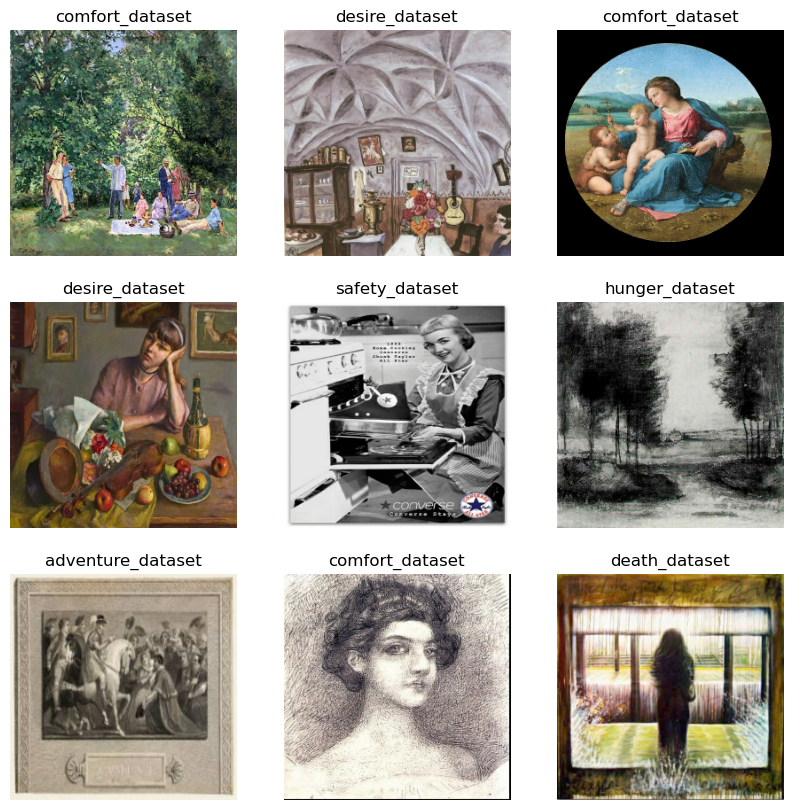

In [21]:
# ------------------IMPORT and PARTITION DATASET-----------------

BATCH_SIZE = 32
IMG_SIZE = (256, 256)
data_dir = 'data/cluster_specific_datasets' 
data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMG_SIZE)

# all data batches
data_batches = tf.data.experimental.cardinality(data)
print('Number of data batches: %d' % data_batches)

# take out twenty percent to use as validation data
val_dataset = data.take(data_batches // 5)
val_batches = tf.data.experimental.cardinality(val_dataset)
print('Number of validation batches: %d' % val_batches)

# use the rest as train data
train_dataset = data.skip(data_batches // 5)
train_batches = tf.data.experimental.cardinality(train_dataset)
print('Number of train batches: %d' % train_batches)

# take out half of validation data and make it the test set
test_dataset = val_dataset.take(val_batches // 2)
test_batches = tf.data.experimental.cardinality(test_dataset)
print('Number of test batches: %d' % test_batches)

# make sure the validation now skips the half taken for the test set
val_dataset = val_dataset.skip(val_batches // 2)
val_batches = tf.data.experimental.cardinality(val_dataset)
print('NEW number of validation batches: %d' % val_batches)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 0 is adventure, 1 comfort, 2 danger, 3 is death, 4 is desire, 
# 5 is excitement, 6 is fitness, 7 is freedom, 8 is hunger,
# 9 is power, 10 is protection, 11 is safety

# My own model + NOT augmented data

In [ ]:
# ------------------BUILD THE MODEL------------------
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

In [ ]:
# ------------------TRAIN THE MODEL------------------
model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# PERFORMANCE OF MY MODEL JUST ON TRAINING AND VAL DATA WITHOUT AUGMENTED TRAINING DATA
# 465/824 [===============>..............] - ETA: 51s - loss: 1.0595 - accuracy: 0.6488

In [ ]:
# ------------------MODEL EVALUATION------------------
eval_metrics = model.evaluate(test_dataset)
print(eval_metrics)

# PERFORMANCE OF MY MODEL IN !TEST! DATA WITHOUT AUGMENTED TRAINING DATA
# 103/103 [==============================] - 5s 48ms/step - loss: 2.6025 - accuracy: 0.3996
# [2.602473497390747, 0.39957523345947266]


In [ ]:
# ------------------PREDICTIONS ON NEW INSTANCES------------------
img = cv2.imread('comfort.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.argmax(yhat)

if yhat == 0: 
    print(f'Predicted class is adventure')
elif yhat == 1:
    print(f'Predicted class is comfort')
elif yhat == 2:
    print(f'Predicted class is danger')
elif yhat == 3:
    print(f'Predicted class is death')
elif yhat == 4:
    print(f'Predicted class is desire')
elif yhat == 5:
    print(f'Predicted class is excitement')
elif yhat == 6:
    print(f'Predicted class is fitness')
elif yhat == 7:
    print(f'Predicted class is freedom')
elif yhat == 8:
    print(f'Predicted class is hunger')
elif yhat == 9:
    print(f'Predicted class is power')
elif yhat == 10:
    print(f'Predicted class is protection')
elif yhat == 11:
    print(f'Predicted class is safety')
else:
    print(f'Something went wrong')


# My own model + augmented data

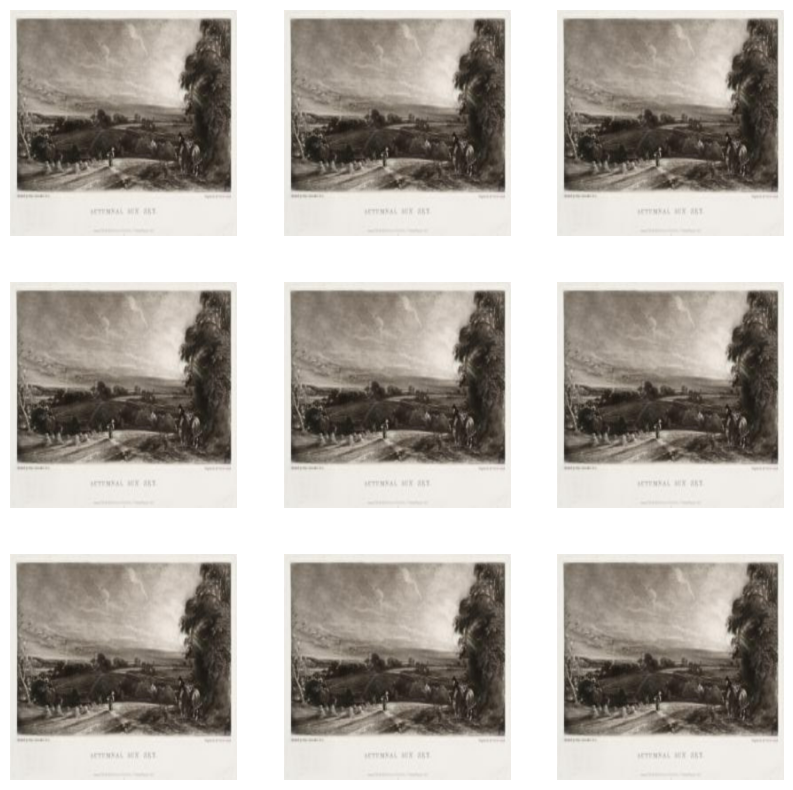

In [25]:
# ------------------CONFIGURE and AUGMENT DATASET-----------------

# Configure the dataset for performance
# use buffered prefetching to load images without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
# use data augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# repeatedly apply these layers to the same image and see the result.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# ------------------TRAIN THE MODEL with AUGMENTED DATA-----------------
# train again but with augmented data

# ------------------TRAIN THE MODEL------------------
model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# PERFORMANCE OF MY MODEL JUST ON TRAINING AND VAL DATA !WITH! AUGMENTED TRAINING DATA
# Epoch 5/5
# 824/824 [==============================] - 129s 155ms/step - loss: 0.4005 - accuracy: 0.8780 - val_loss: 3.9329 - val_accuracy: 0.4093

In [ ]:
# ------------------MODEL EVALUATION with AUGMENTED DATA-----------------

eval_metrics = model.evaluate(test_dataset)
print(eval_metrics)

# PERFORMANCE OF MY MODEL IN !TEST! DATA !WITH! AUGMENTED TRAINING DATA


In [ ]:
# ------------------PREDICTIONS ON NEW INSTANCES------------------
img = cv2.imread('comfort.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.argmax(yhat)

if yhat == 0: 
    print(f'Predicted class is adventure')
elif yhat == 1:
    print(f'Predicted class is comfort')
elif yhat == 2:
    print(f'Predicted class is danger')
elif yhat == 3:
    print(f'Predicted class is death')
elif yhat == 4:
    print(f'Predicted class is desire')
elif yhat == 5:
    print(f'Predicted class is excitement')
elif yhat == 6:
    print(f'Predicted class is fitness')
elif yhat == 7:
    print(f'Predicted class is freedom')
elif yhat == 8:
    print(f'Predicted class is hunger')
elif yhat == 9:
    print(f'Predicted class is power')
elif yhat == 10:
    print(f'Predicted class is protection')
elif yhat == 11:
    print(f'Predicted class is safety')
else:
    print(f'Something went wrong')


## VGG MODEL (PRETRAINED) + augmented data

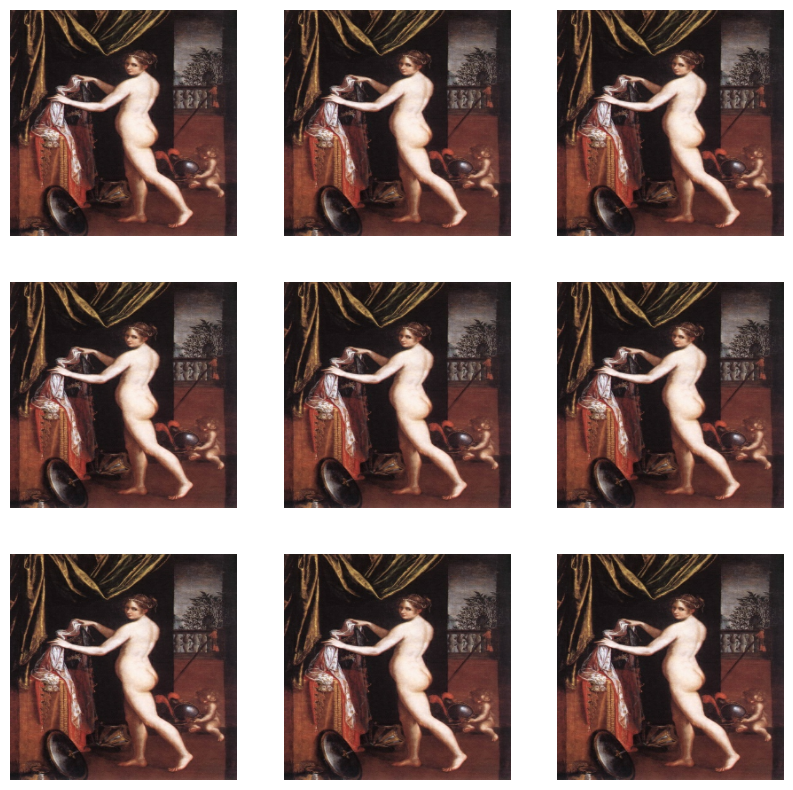

In [29]:
# ------------------CONFIGURE and AUGMENT DATASET-----------------

# Configure the dataset for performance
# use buffered prefetching to load images without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
# use data augmentation

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.8),
])

# repeatedly apply these layers to the same image and see the result.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [7]:
# ------------------BUILD THE BASE MODEL------------------
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)
base_model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
# ------------------TEST BASE MODEL------------------

# see what the base model does to an example batch of images when employed as a feature extractor

# converts each 256x256x3 image into a 8x8x512 block of features

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

(32, 256, 256, 3)
(32, 8, 8, 512)


In [9]:
# ------------------FREEZE CONVOLUTIONAL BASE------------------
base_model.trainable = False

In [10]:
# ------------------ADD CLASSIFICATION HEAD------------------
# To generate predictions from the block of features, average over the spatial 8x8 spatial locations, 
# # using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 512-element vector per image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
prediction_layer = tf.keras.layers.Dense(12, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 512)
(32, 12)


In [12]:
# ------------------BUILD THE MODEL------------------
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers 
# using the Keras Functional API. 
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])
# model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)
# result is 2 because tehre are two tf.Variable objects -- the weights and the biases -- that are trainable

NameError: name 'data_augmentation' is not defined

In [ ]:
# ------------------TRAIN THE MODEL------------------
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# PERFORMANCE OF MY MODEL JUST ON TRAINING AND VAL DATA WITHOUT AUGMENTED TRAINING DATA
# 

In [ ]:
# ------------------CALCULATE LEARNING CURVES------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# ------------------MODEL EVALUATION------------------
eval_metrics = model.evaluate(test_dataset)
print(eval_metrics)

# 411/411 [==============================] - 8s 19ms/step - loss: 2.0236 - accuracy: 0.3966
# [2.0236144065856934, 0.3965936601161957]

In [ ]:
# ------------------PREDICTIONS ON NEW INSTANCES------------------
img = cv2.imread('comfort.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.argmax(yhat)

if yhat == 0: 
    print(f'Predicted class is adventure')
elif yhat == 1:
    print(f'Predicted class is comfort')
elif yhat == 2:
    print(f'Predicted class is danger')
elif yhat == 3:
    print(f'Predicted class is death')
elif yhat == 4:
    print(f'Predicted class is desire')
elif yhat == 5:
    print(f'Predicted class is excitement')
elif yhat == 6:
    print(f'Predicted class is fitness')
elif yhat == 7:
    print(f'Predicted class is freedom')
elif yhat == 8:
    print(f'Predicted class is hunger')
elif yhat == 9:
    print(f'Predicted class is power')
elif yhat == 10:
    print(f'Predicted class is protection')
elif yhat == 11:
    print(f'Predicted class is safety')
else:
    print(f'Something went wrong')


## VGG MODEL (FINETUNED) + augmented data

In [ ]:
# ------------------UN-FREEZE TOP LAYERS OF THE MODEL------------------
base_model.trainable = True

# Take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# ------------------COMPILE THE MODEL------------------
# B/c training a much larger model and want to readapt the pretrained weights, 
# it is important to use a lower learning rate at this stage. 
# Otherwise, the model could overfit very quickly.

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               metrics=['accuracy'])



model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()
len(model.trainable_variables)


In [ ]:
# ------------------CONTINUE TRAINING THE MODEL------------------
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

In [ ]:
# ------------------CALCULATE FINETUNED LEARNING CURVES------------------

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# ------------------MODEL EVALUATION------------------
eval_metrics = model.evaluate(test_dataset)
print(eval_metrics)

In [ ]:
# ------------------PREDICTIONS ON NEW INSTANCES------------------
img = cv2.imread('comfort.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat = np.argmax(yhat)

if yhat == 0: 
    print(f'Predicted class is adventure')
elif yhat == 1:
    print(f'Predicted class is comfort')
elif yhat == 2:
    print(f'Predicted class is danger')
elif yhat == 3:
    print(f'Predicted class is death')
elif yhat == 4:
    print(f'Predicted class is desire')
elif yhat == 5:
    print(f'Predicted class is excitement')
elif yhat == 6:
    print(f'Predicted class is fitness')
elif yhat == 7:
    print(f'Predicted class is freedom')
elif yhat == 8:
    print(f'Predicted class is hunger')
elif yhat == 9:
    print(f'Predicted class is power')
elif yhat == 10:
    print(f'Predicted class is protection')
elif yhat == 11:
    print(f'Predicted class is safety')
else:
    print(f'Something went wrong')


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = np.argmax(predictions)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1) 

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")